#Project 1. Create a tree bloom classifier to distinguish cherry-like blooms.

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/gdrive


In [2]:
%cd '/content/drive/My Drive/Colab Notebooks'
# %mkdir projects

/content/drive/My Drive/Colab Notebooks


In [3]:
# %mkdir projects/tree_bloom
%cd projects/tree_bloom

/content/drive/My Drive/Colab Notebooks/projects/tree_bloom


#first create bloom dataset

Download Google Images for cherry, crabapple, apricot, pear, peach, plum tree bloom. Click ctr + shite + J, then copy & paste the code below, which downloads the URL to a csv file. 

```
urls=Array.from(document.querySelectorAll('.rg_i')).map(el=> el.hasAttribute('data-src')?el.getAttribute('data-src'):el.getAttribute('data-iurl'));
window.open('data:text/csv;charset=utf-8,' + escape(urls.join('\n')));
```



In [0]:
from fastai.vision import *
from fastai import *

In [5]:
# bloom = pd.read_csv("bloom.csv")
# bloom.head(10)

,type,name_exclude,class
0,cherry tree bloom,tree bloom,cherry
1,crabapple tree bloom,tree bloom,crabapple
2,apricot tree bloom,tree bloom,apricot
3,pear tree bloom,tree bloom,pear
4,peach tree bloom,tree bloom,peach


In [25]:
class_col = ['cherry', 'crabapple', 'pear']
# type(class_col)
class_col

['cherry', 'crabapple', 'pear']

In [7]:
for x in class_col:
  print(x)
  path = Path('data')
  dest = path/x
  dest.mkdir(parents=True, exist_ok=True)

cherry
crabapple
apricot
pear
peach


In [0]:
for x in class_col:
  path = Path('data')
  file = x + '.csv'
  print(path/x/file)
  dest = path/x
  download_images(dest/file, dest, max_pics=400)

In [26]:
for c in class_col:
  print(c)
  verify_images(path/c, delete=True, max_size=500)

cherry


crabapple


pear


# Now we can create a databunch, and explore the data we downloaded

In [0]:
tfms = get_transforms(do_flip=True)
# doc(get_transforms)

In [0]:
# doc(ImageDataBunch.from_folder)

In [0]:
bloom_data = ImageDataBunch.from_folder(path="data", train=".",
                                        valid_pct=0.2, size =224,
                                        seed=42,
                                        ds_tfms=tfms).normalize(imagenet_stats)

In [28]:
bloom_data.classes

['cherry', 'crabapple', 'pear']

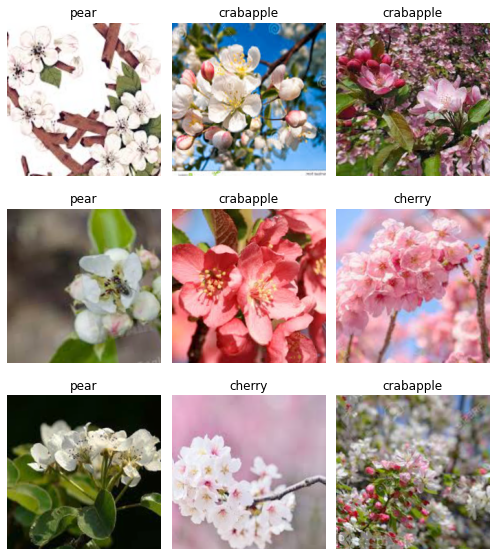

In [29]:
bloom_data.show_batch(rows=3,figsize=(7,8))

In [30]:
bloom_data.c, len(bloom_data.train_ds), len(bloom_data.valid_ds)

(3, 636, 159)

#Train model

In [0]:
learn = cnn_learner(bloom_data, models.resnet34, metrics=error_rate)

In [32]:
learn

Learner(data=ImageDataBunch;

Train: LabelList (636 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
cherry,cherry,cherry,cherry,cherry
Path: data;

Valid: LabelList (159 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
pear,pear,cherry,pear,cherry
Path: data;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

In [33]:
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,error_rate,time
0,1.401879,0.812073,0.232704,00:08
1,1.027996,0.548486,0.132075,00:08
2,0.850992,0.428748,0.125786,00:08
3,0.703745,0.401074,0.125786,00:08
4,0.634961,0.391914,0.113208,00:08


In [0]:
learn.save('stage_1') # will create models folder and save 'stage_1' under data/models.

now can check the learning rate in the fine-tune step.

In [0]:
learn.load('stage_1')

In [36]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


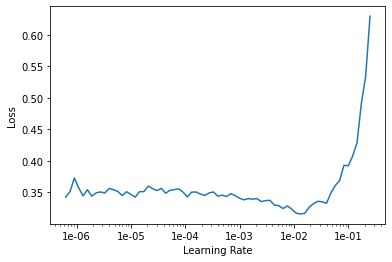

In [37]:
learn.recorder.plot()

# stage2: unfreeze and train the whole thing. Use the discriminative lr, default lr before unfreeze step is 3e-3 (which often works well), slice(3e-3,3e-4). 

In [0]:
learn.unfreeze()

In [41]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


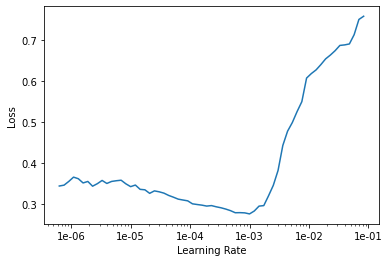

In [42]:
learn.recorder.plot()

In [43]:
learn.fit_one_cycle(2, max_lr=slice(3e-5, 3e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.405913,0.346788,0.094340,00:08
1,0.350986,0.404585,0.094340,00:08


In [0]:
learn.save('stage_2')

#check results

In [0]:
learn.load('stage_2')

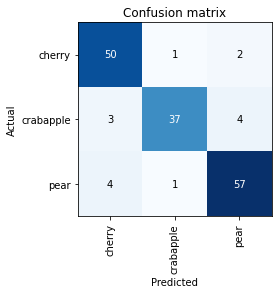

In [53]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

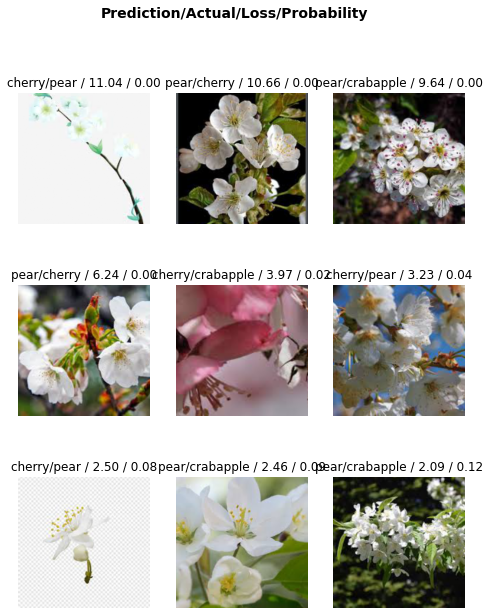

In [56]:
interp.plot_top_losses(9,figsize=(8,10))

In [57]:
interp.most_confused(min_val=2)

[('crabapple', 'pear', 4),
 ('pear', 'cherry', 4),
 ('crabapple', 'cherry', 3),
 ('cherry', 'pear', 2)]